<a href="https://colab.research.google.com/github/linesn/reddit_analysis/blob/main/Facebook_impression_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Facebook post impressions
Nicholas Lines

This notebook is my work for Module 8 of EN.605.633.81.SP21 Social Media Analytics.  
The problem prompt is  
> Design a supervised machine learning classifier that will predict whether the impression of Facebook posts will be greater than 1,000 based on data such as the type of post, weekday or weekend, and weather. Implement the classifier and test it using Python. The data corpus contains data from Facebook on recent posts for a bicycle shop. The columns are Post Message, Message Type, Date and Time of Post, Number of Impression, Weather indicator for snow or rain, and weekday or weekend indicator for the post.  
> Test your classifier and calculate precision and recall. Turn in Python code for the classifier

The data used was provided by the instructor.

## Environment setup
I'll try to use `scikit-learn` built-in functions and structures wherever possible for consistency and ease of review.

In [25]:
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
if 'COLAB_GPU' in os.environ: # a hacky way of determining if you are in colab.
  print("Notebook is running in colab")
  from google.colab import drive
  drive.mount("/content/drive")
  DATA_DIR = "./drive/My Drive/Data/"
  
else:
  # Get the system information from the OS
  PLATFORM_SYSTEM = platform.system()

  # Darwin is macOS
  if PLATFORM_SYSTEM == "Darwin":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver")
  elif PLATFORM_SYSTEM == "Windows":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver.exe")
  else:
      logging.critical("Chromedriver not found or Chromedriver is outdated...")
      exit()
  DATA_DIR = "../Data/"

Notebook is running in colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data read-in and feature review

In [58]:
df = pd.read_excel(DATA_DIR + "raw/SocialMediaInsightsforMachineLearning.xlsm", parse_dates=True)

In [59]:
df.head()

,Post Message,Type,Posted,Impressions,Weather,Weekend
0,"Dont forget, our Spring Savings Event is going...",Photo,2016-03-03 03:13:12,1220.0,Snow,N
1,https://www.facebook.com/natalie.birner/posts/...,SharedVideo,2016-03-03 06:05:04,165.0,Snow,N
2,Got a new bike in the last year or so and look...,Photo,2016-03-04 12:25:06,1398.0,Snow,Y
3,Just in! New HiVis Endura jerseys and riding s...,Photo,2016-03-04 13:16:22,1174.0,Snow,Y
4,Sale ends March 31,Photo,2016-03-04 14:19:07,1030.0,Snow,Y


In [60]:
print(f"There are {df.shape[0]} data points and {df.shape[1]} columns")

There are 102 data points and 6 columns


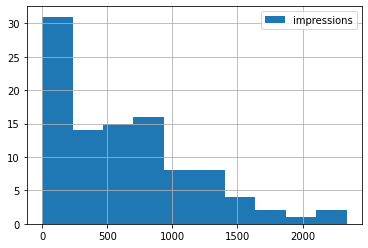

In [61]:
df.Impressions.hist(label="impressions");
legend();

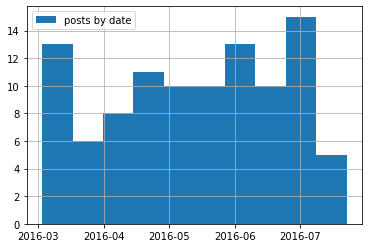

In [62]:
df.Posted.hist(label="posts by date")
legend();

Let's do some gentle feature engineering, using one-hot or dummy encoding to represent categorical data, and extracting a few features from the post body, extract time of day from the post time, etc.

In [65]:
df['num_hashtags'] = df["Post Message"].str.count("#") # check if the hash symbol is used
df['post_length'] = df["Post Message"].str.len() # get the length of the string
df['contains_link'] = int(bool(df["Post Message"].str.count("http") +  df["Post Message"].str.count("www"))) # check if http or www are used in the string
df['Time'] = df.Posted.dt.hour * 60 + df.Posted.dt.minute

In [66]:
df["Post Message"].str.count("http")

0      0.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
97     0.0
98     0.0
99     0.0
100    0.0
101    NaN
Name: Post Message, Length: 102, dtype: float64

In [ ]:
df.tail()

In [42]:
Types_df = pd.get_dummies(df.Type, prefix='Type')
Weather_df = pd.get_dummies(df.Weather, prefix='Weather')
Weekend_df = pd.get_dummies(df.Weekend, prefix='Weekend', drop_first=True)
df = pd.concat([df, Types_df, Weather_df, Weekend_df], axis=1)

In [43]:
df.head()

,Post Message,Type,Posted,Impressions,Weather,Weekend,Type_Link,Type_Photo,Type_SharedVideo,Type_Status,Type_Video,Weather_Rain,Weather_Snow,Weather_Thunder,Weekend_Y
0,"Dont forget, our Spring Savings Event is going...",Photo,2016-03-03 03:13:12,1220.0,Snow,N,0,1,0,0,0,0,1,0,0
1,https://www.facebook.com/natalie.birner/posts/...,SharedVideo,2016-03-03 06:05:04,165.0,Snow,N,0,0,1,0,0,0,1,0,0
2,Got a new bike in the last year or so and look...,Photo,2016-03-04 12:25:06,1398.0,Snow,Y,0,1,0,0,0,0,1,0,1
3,Just in! New HiVis Endura jerseys and riding s...,Photo,2016-03-04 13:16:22,1174.0,Snow,Y,0,1,0,0,0,0,1,0,1
4,Sale ends March 31,Photo,2016-03-04 14:19:07,1030.0,Snow,Y,0,1,0,0,0,0,1,0,1


In [44]:
df.corr()

,Impressions,Type_Link,Type_Photo,Type_SharedVideo,Type_Status,Type_Video,Weather_Rain,Weather_Snow,Weather_Thunder,Weekend_Y
Impressions,1.000000,0.053028,0.480979,-0.138842,-0.524618,-0.034063,0.059085,0.081404,0.073539,-0.355357
Type_Link,0.053028,1.000000,-0.387298,-0.043994,-0.172559,-0.062849,-0.006424,0.052275,-0.043994,-0.020657
Type_Photo,0.480979,-0.387298,1.000000,-0.176068,-0.690596,-0.251526,-0.096203,0.059180,0.113592,-0.141605
Type_SharedVideo,-0.138842,-0.043994,-0.176068,1.000000,-0.078446,-0.028571,-0.102214,0.241300,-0.020000,-0.025355
Type_Status,-0.524618,-0.172559,-0.690596,-0.078446,1.000000,-0.112066,0.134594,-0.150572,-0.078446,0.229285
Type_Video,-0.034063,-0.062849,-0.251526,-0.028571,-0.112066,1.000000,0.066752,-0.054841,-0.028571,-0.036221
Weather_Rain,0.059085,-0.006424,-0.096203,-0.102214,0.134594,0.066752,1.000000,-0.196193,-0.102214,0.059237
Weather_Snow,0.081404,0.052275,0.059180,0.241300,-0.150572,-0.054841,-0.196193,1.000000,-0.038389,0.069523
Weather_Thunder,0.073539,-0.043994,0.113592,-0.020000,-0.078446,-0.028571,-0.102214,-0.038389,1.000000,-0.169031
Weekend_Y,-0.355357,-0.020657,-0.141605,-0.025355,0.229285,-0.036221,0.059237,0.069523,-0.169031,1.000000


In [54]:
df.Posted[0].hour * 60 + df.Posted[0].minute

193